In [8]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [10]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon


def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

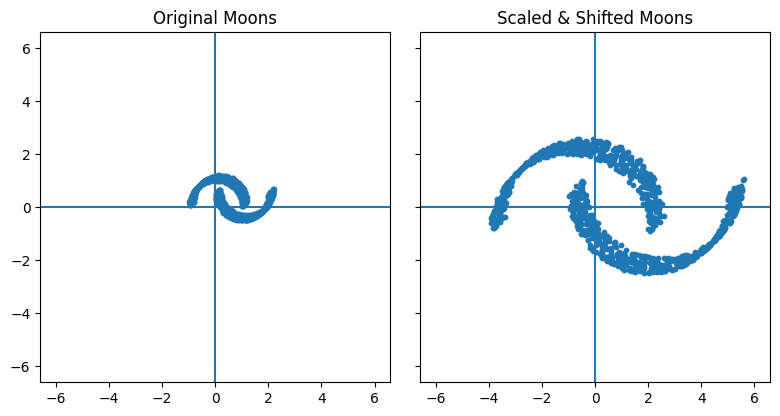

In [5]:
def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


x0, _ = generate_moons(1000, noise=0.2)
y0 = x0 * 3 - 1

# 统一坐标范围
all_data = np.vstack([x0, y0])
max_val = np.max(np.abs(all_data))  # 找出绝对值最大值
xmin, xmax = -max_val, max_val
ymin, ymax = -max_val, max_val

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axes[0].scatter(x0[:, 0], x0[:, 1], s=10)
axes[0].set_title("Original Moons")

axes[1].scatter(y0[:, 0], y0[:, 1], s=10)
axes[1].set_title("Scaled & Shifted Moons")

for ax in axes:
    ax.set_xlim(xmin - 1, xmax + 1)
    ax.set_ylim(ymin - 1, ymax + 1)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(0)
    ax.axvline(0)

plt.tight_layout()
plt.show()

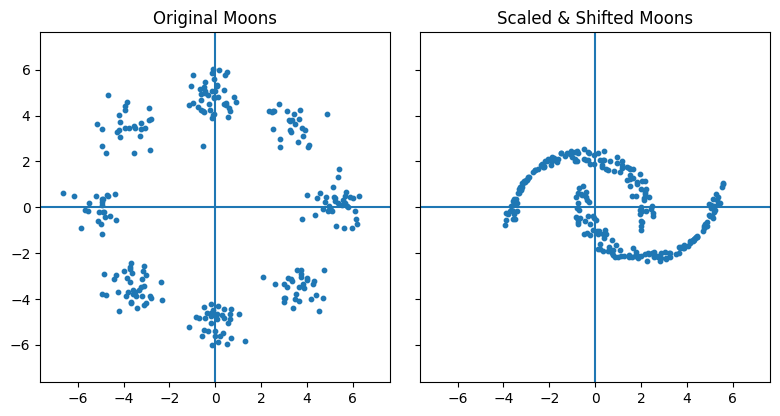

In [6]:
x0 = sample_8gaussians(256)
y0 = sample_moons(256)

# 统一坐标范围
all_data = np.vstack([x0, y0])
max_val = np.max(np.abs(all_data))  # 找出绝对值最大值
xmin, xmax = -max_val, max_val
ymin, ymax = -max_val, max_val

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axes[0].scatter(x0[:, 0], x0[:, 1], s=10)
axes[0].set_title("Original Moons")

axes[1].scatter(y0[:, 0], y0[:, 1], s=10)
axes[1].set_title("Scaled & Shifted Moons")

for ax in axes:
    ax.set_xlim(xmin - 1, xmax + 1)
    ax.set_ylim(ymin - 1, ymax + 1)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(0)
    ax.axvline(0)

plt.tight_layout()
plt.show()

5000: loss 9.408 time 14.72
torch.Size([100, 1024, 2])


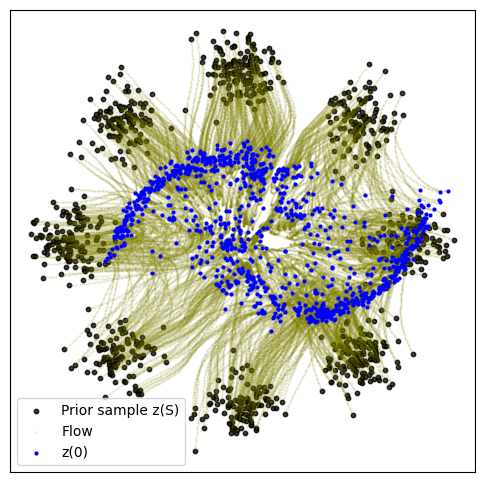

10000: loss 8.216 time 14.93
torch.Size([100, 1024, 2])


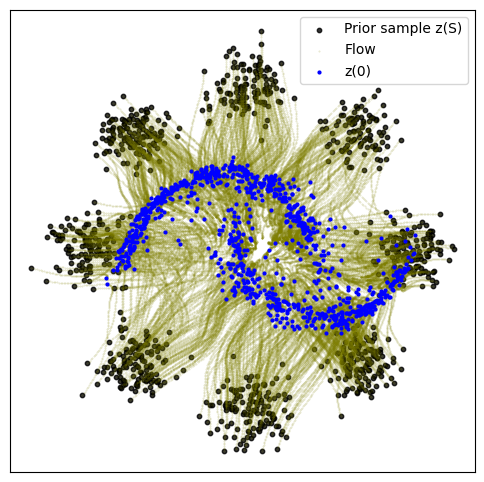

15000: loss 8.435 time 14.86
torch.Size([100, 1024, 2])


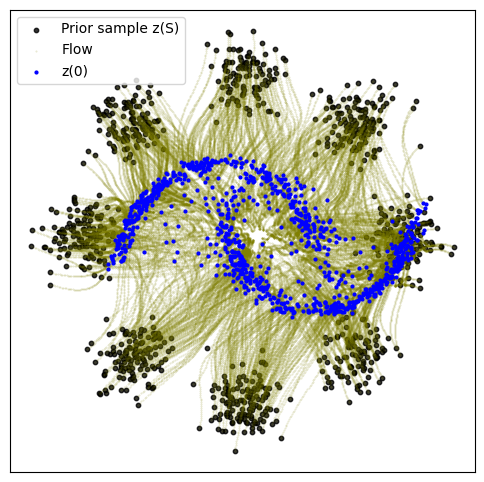

20000: loss 8.536 time 15.24
torch.Size([100, 1024, 2])


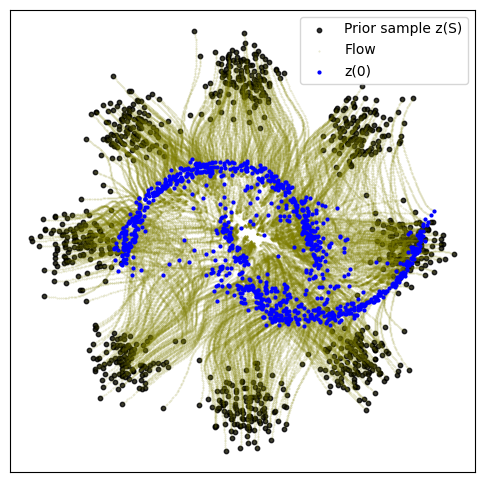

CPU times: total: 7min 54s
Wall time: 1min


In [11]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k + 1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            print(traj.shape)
            plot_trajectories(traj.cpu().numpy())
